# Multilevel Delayed Acceptance - Bayesian Linear Regression

*Tim Dodwell, University of Exeter and The Alan Turing Insitute, t.dodwell@exeter.ac.uk. Updated 23/9/20.*

Our first example considers a simple Bayesian Linear Regression problem using a dataset from health statistics. The **bodyfat** data set, available [data here](https://github.com/merliseclyde/BAS), provides body fat measurements of $N = 253$ males (${\bf d}$), alongside measurements of the circumference of their abdomens (${\bf x}$). Body fat is recognised as a good metric for determining the general health of an individual, however it is much more complex to measure compared with measuring abdomen circumference.  

From the dataset,  see below, it is reasonable to build a predictive model between the two parameters defined by a simple linear relationship. We therefore define the {\em observation model} between our model and data as

\begin{equation}
{\bf d} = \beta_0 + \beta_1 {\bf x} + \epsilon, \quad \mbox{where} \quad \epsilon \sim \mathcal N(0, \sigma^2 \mathbb I_N).
\end{equation}

The aim is to determine the distribution of the three parameters $\theta = [\beta_0, \beta_1, \sigma^2]^T$, given our complete dataset ${\bf d}$, i.e. obtain samples from $\pi(\theta|{\bf d})$. Independent, weakly informative, priors are specified for each parameter such that

$$
\beta_0 \sim \mathcal N(-40.0,5.0^2), \quad \beta_1 \sim \mathcal N(0.65, 2.0^2) \quad \mbox{and} \quad \sigma^2 \sim \mbox{Inv-Gamma}(3, 46).
$$

To test adaptive MLDA on this first example, a simple two-level hierarchy is constructed by generating a coarse model consisting of $20\%$ of the total data set, denoted ${\bf d}_0 \subset {\bf d}$. This approximate model is therefore $1/5$th of the cost of the full model.


In this example, to demonstrate the Multilevel variance reduction we define the Quantity of Interest ($Q$) for our problem. Recent communications from the UK's National Health Service suggest that a body fat percentage of $<17\%$ is healthy for a male. We therefore define $Q$ as the predicted abdomen circumference associated with $17\%$ body fat, i.e. 

\begin{equation}
Q(\theta) = (17\% - \beta_0 - \epsilon) /\beta_1, \quad \mbox{where} \quad \epsilon \sim \mathcal N(0, \sigma^2)
\end{equation}

for which we wish to estimate 

$$\mathbb E_{\pi(\theta|\mathcal D)} [Q] = \int_{\Theta} Q(\theta)\pi(\theta|\mathcal D)\;d\theta.$$

### Import modules

In [41]:
import os as os
import sys as sys
import time as time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

import pandas as pd

RANDOM_SEED = 1555
np.random.seed(RANDOM_SEED)

## Load Data and Visualise Data Sets

We first load the full data set, which was originally available from [data here](https://github.com/merliseclyde/BAS), this contains a number of body measurements for the $253$ individuals. Just body fat percentage and abdoment circumference are taken out. Here they are then coverted into a simple 'numpy' array.

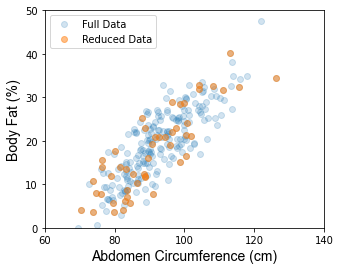

In [42]:
df = pd.read_csv('data/bodyfat.csv')

Data = df[["Bodyfat","Abdomen"]].to_numpy()

axis_font = {'fontname':'Arial', 'size':'14'}

_, ax = plt.subplots(figsize=(5, 4))
ax.plot(Data[:,1],Data[:,0], "o", alpha = 0.2, label="Full Data")
ax.plot(Data[0:50,1],Data[0:50,0], "o", alpha = 0.5, label="Reduced Data")
ax.set_facecolor('w')
ax.set_ylabel("Body Fat (%)", **axis_font)
ax.set_xlabel("Abdomen Circumference (cm)", **axis_font)
ax.set_xticks([60., 80, 100., 120., 140., 160.])
ax.set_ylim([0.0, 50.0])
ax.set_xlim([60.0, 140.0])
ax.legend();
plt.savefig("bodyFat_data.pdf")


## Define Level-dependent Model class

The next step, which is unique to each model, is to define a level dependent model class (a `tt.Op` or Theano operator) for your problem. The important part of this is the definition of the `perform(...)` function, which returns the log-likelihood for proposed inputs $\theta$ given data. If there is a quantity of interest $Q$, it is also computed within this function. A stripped down example for the linear regression problem is provide below.

*Remark: There are various ways to implement this model in PyMC3. For a Bayesian Linear Regression problem, the way presented is overkill. However to be consistent across all examples, the approach of defining your own `tt.Op` class, allows a user to readily link with external codes which might be required to compute a general likelihood. In the examples which following the remainder of Sec. 3, these will include solver an ode, pde and a quadrature problem, and by their nature require more complex model definitions.*

In [43]:
class BodyFat(tt.Op):
    
    # Specify what type of object will be passed and returned to the Op.
    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)
    
    def __init__(self, Data, pymc3_model, level = -1):
        
        self.level = level
        if(level == 0):
            self.Data = Data[0:50,:] # Thins Data for Coarse Model
        else:
            self.Data = Data
        
        self.pymc3_model = pymc3_model
        
        
    def perform(self, node, inputs, outputs):
        
        # the method that is used when calling the Op
        
        [beta0, beta1, sig2] = inputs[0]  # this will contain my variables

        # call the log-likelihood function
        logl = -np.mean((beta0 + beta1*self.Data[:,1] - self.Data[:,0])**2)/(2.0 * sig2)
        
        Q = (17.0 - beta0) / beta1
        
        self.pymc3_model.Q.set_value(Q) # Store QoI
        
        outputs[0][0] = np.array(logl)  # output the log-likelihood
        

## Build Hierarchy of PyMC3 Models

In [44]:
logl = []
modelHierarchy = []

maxLevel = 2

for j in range(maxLevel):

    with pm.Model() as model:

        Q = pm.Data('Q', np.float(0.0))

        # Define priors
        beta0 = pm.Normal('beta0', mu= -40.0, sigma=5.)
        beta1 = pm.Normal('beta1', mu=0.5, sigma=2.0)
        sig2 = pm.InverseGamma('sig2', alpha=3.0, beta=46.0)

        # wrap parameters to tensor vector
        theta = tt.as_tensor_variable([beta0, beta1, sig2])

        # Build instances of "BodyFat" class for level j
        logl.append(BodyFat(Data, model, j))

        pm.Potential('likelihood', logl[j](theta))

        modelHierarchy.append(model)

## MLDA Sampling

In [45]:
numSamples = 10000
numChains = 4
numCores = 1
burnIn = 1000
subSampling = 5

with modelHierarchy[-1]: # with the finest level model
    
    step = pm.MLDA(coarse_models=[modelHierarchy[0]],
                   subsampling_rates=[subSampling],
                   variance_reduction=True,
                   store_Q_fine=True)
    
    trace = pm.sample(draws=numSamples, chains=numChains, cores = numCores, tune=burnIn, step=step, discard_tuned_samples=True,
                   random_seed=RANDOM_SEED)

    

/Users/td336/Dropbox/pymc3/pymc3/step_methods/mlda.py:453: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  warnings.warn(


## Show summary statistics for model parameters

In [46]:
pm.stats.summary(trace)

/Users/td336/miniconda3/envs/pymc3_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0,-39.997,4.932,-49.447,-30.883,0.042,0.030,13474.0,13364.0,13481.0,16654.0,1.0
beta1,0.639,0.084,0.478,0.794,0.001,0.001,11080.0,10970.0,11293.0,13799.0,1.0
sig2,37.887,47.559,6.041,93.043,0.432,0.306,12094.0,12094.0,11060.0,12917.0,1.0


/Users/td336/miniconda3/envs/pymc3_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13365cb20>,
      dtype=object)

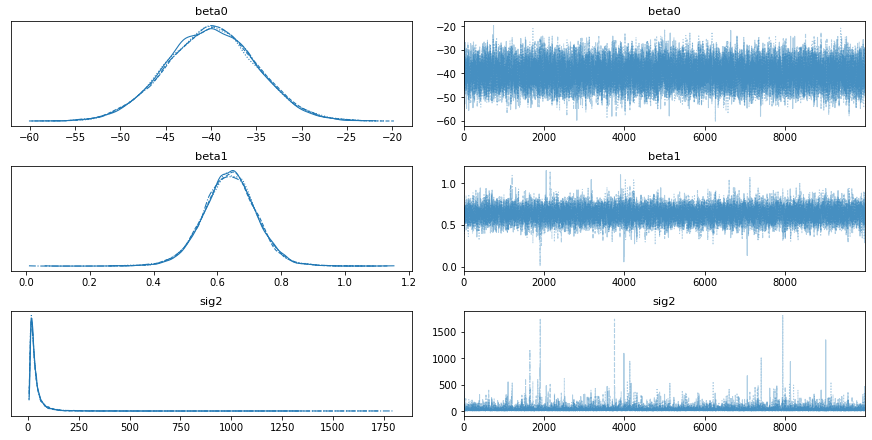

In [31]:
pm.plots.traceplot(trace)

{'Q_0',
 'Q_1',
 'Q_1_0',
 'accept',
 'accepted',
 'base_lambda',
 'base_scaling',
 'tune'}

# Plots for publication

The general plotting in pymc3 does not provide general flexibility to build your own more complex figures. We therefore unwrap the traces, and build our own plots using the python package seaborn in combination with matplotlib

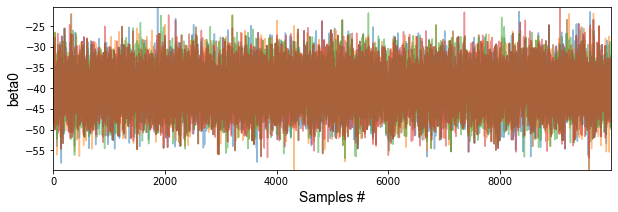

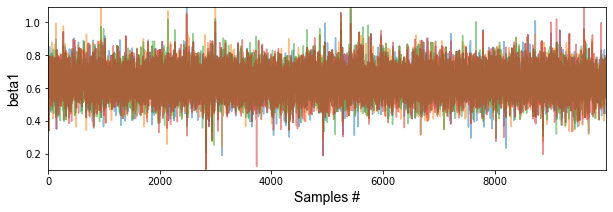

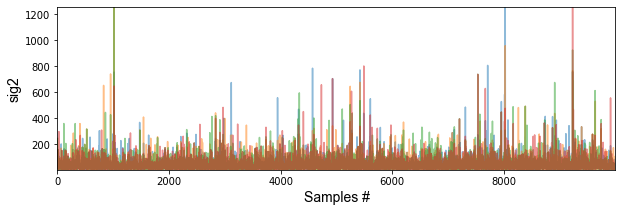

In [48]:
import seaborn as sns

var_names = ['beta0', 'beta1', 'sig2']

Chains = ['Chain #1', 'Chain #2', 'Chain #3', 'Chain #4']

samples = []

df = []


for i in range(len(var_names)):
    
    _, ax = plt.subplots(figsize=(10, 3))
    
    tmp = trace.get_values(var_names[i])
    
    samples.append(tmp.reshape((numSamples, numChains)))
    
    df.append(pd.DataFrame(data=samples[i], columns=Chains))
    
    for j in range(4):
        ax.plot(samples[i][:,j], "-", alpha = 0.5, label="Full Data")
    
    ax.set_facecolor('w')
    ax.set_ylabel(var_names[i], **axis_font)
    ax.set_xlabel("Samples #", **axis_font)
    
    ax.set_xlim(0, samples[i].shape[0]-1)
    
    ax.set_ylim(samples[i][:,0].min(), samples[i][:,0].max())
   
    #ax[i].legend();
    
    
    



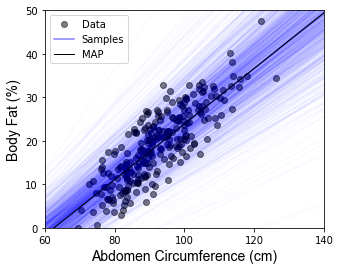

In [49]:
_, ax = plt.subplots(figsize=(5, 4))
ax.plot(Data[:,1],Data[:,0], "ko", alpha = 0.5, label="Data")

x = np.linspace(60.0, 160.0, 3)

nSamples = 1000

for i in range(nSamples):
    
    idx = np.random.randint(samples[0].shape[0])
    
    chain_id = np.random.randint(numChains)
    
    ax.plot(x,samples[0][idx,chain_id] + samples[1][idx,chain_id] * x, 'b-',alpha = 0.02)

mean_beta0 = 0.0
mean_beta1 = 0.0
    
for j in range(numChains):
    
    mean_beta0 += np.mean(samples[0][:,j])/numChains
    
    mean_beta1 += np.mean(samples[1][:,j])/numChains

ax.plot(x,mean_beta0 + mean_beta1 * x, 'b-',alpha = 0.5, label="Samples")    
ax.plot(x,mean_beta0 + mean_beta1 * x, 'k-',alpha = 1.0, label="MAP", linewidth = 1.0)
    
ax.set_facecolor('w')
ax.set_ylabel("Body Fat (%)", **axis_font)
ax.set_xlabel("Abdomen Circumference (cm)", **axis_font)
ax.set_xticks([60., 80, 100., 120., 140., 160.])
ax.set_ylim([0.0, 50.0])
ax.set_xlim([60.0, 140.0])
ax.legend();
plt.savefig("bodyFat_samples.pdf")

### Show traceplots

#### 1) Extract quantities of interest from the traces
This requires some reshaping with numpy

In [50]:
from scipy import stats

# MLDA without VR
tmpQ1 = trace.get_sampler_stats("Q_1")
tmpQ0 = np.concatenate(trace.get_sampler_stats("Q_0")).reshape((numChains * numSamples * 5))
tmpQ10 = np.concatenate(trace.get_sampler_stats("Q_1_0")).reshape((numChains * numSamples))

Q_1 = np.zeros(tmpQ1.shape)
Q_0 = np.zeros(tmpQ0.shape)
Q_10 = np.zeros(tmpQ10.shape)


for i in range(tmpQ1.shape[0]):
    Q_1[i] = tmpQ1[i]

for i in range(tmpQ0.shape[0]):
    Q_0[i] = tmpQ0[i]

for i in range(tmpQ10.shape[0]):
    Q_10[i] = tmpQ10[i]

kde1 = stats.gaussian_kde(Q_1)
kde0 = stats.gaussian_kde(Q_0)
kde10 = stats.gaussian_kde(Q_10)
x = np.linspace(Q_1.min(), Q_1.max(), 10000)
Q1 = kde1(x)
Q0 = kde0(x)
Q10 = kde10(x)



LinAlgError: singular matrix

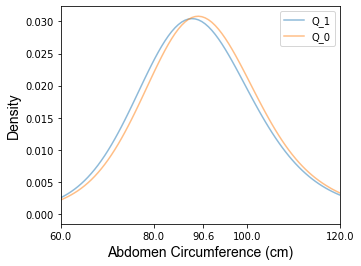

In [35]:
_, ax = plt.subplots(figsize=(5, 4))
ax.plot(x, Q1, "-", alpha = 0.5, label="Q_1")
ax.plot(x, Q0, "-", alpha = 0.5, label="Q_0")
#ax.plot(x, Q10, "--", alpha = 0.5, label="Q_10")

ax.set_facecolor('w')
ax.set_ylabel("Density", **axis_font)
ax.set_xlabel("Abdomen Circumference (cm)", **axis_font)
ax.set_xticks([60., 80, np.mean(Q_1), 100., 120., 140., 160.])
ax.set_xlim([60.0, 120.0])
ax.legend();
plt.savefig("bodyFat_Q.pdf")

In [37]:
# MLDA with VR

# Estimates
Q_mean_standard = tmpQ1.mean()
Q_mean_vr = tmpQ0.mean() + tmpQ10.mean()

print(f"Q_0 mean = {tmpQ0.mean()}")
print(f"Q_1_0 mean = {tmpQ10.mean()}")
print(f"Q_1 mean = {tmpQ1.mean()}")
print(f"Standard method:    Mean: {Q_mean_standard}")
print(f"VR method:    Mean: {Q_mean_vr}")

Q_0 mean = 91.35426510645867
Q_1_0 mean = 0.21002093853746606
Q_1 mean = 90.60649964213977
Standard method:    Mean: 90.60649964213977
VR method:    Mean: 91.56428604499614


#### Calculate variances of Q quantity samples
This shows that the variances of the differences is orders of magnitude smaller than the variance of any of the chains

In [38]:
tmpQ1.var()

2782.483371256204

In [39]:
tmpQ0.var()

3668.812251033988

In [40]:
tmpQ10.var()

1211.7623924879533

#### Calculate standard error of each term using ESS

In [ ]:
ess_Q0 = az.ess(np.array(Q_0, np.float64))
ess_Q_1_0 = az.ess(np.array(Q_1_0, np.float64))
ess_Q_2_1 = az.ess(np.array(Q_2_1, np.float64))
ess_Q2 = az.ess(np.array(Q_2, np.float64))

In [ ]:
# note that the chain in level 2 has 25 times fewer samples than the chain in level 0 (because nsub=5)
print(ess_Q2, ess_Q0, ess_Q_1_0, ess_Q_2_1, ess_Q2)

Standard errors are estimated by $Var(Q) \over ESS(Q)$. 
It is clear that the differences have standard errors much lower than levels 0 and 2

In [ ]:
Q_2.var()/ess_Q2

In [ ]:
Q_0.var()/ess_Q0

In [ ]:
Q_1_0.var()/ess_Q_1_0

In [ ]:
Q_2_1.var()/ess_Q_2_1

#### Calculate total standard errors of the two competing estimates with different chunks of the sample
The graph shows how the errors decay when we collect more samples, demonstrating the gains of the VR technique in terms of standard error reduction.

In [ ]:
step = 100

Q2_SE = np.zeros(int(ndraws/step)-1)
Q0_SE = np.zeros(int(ndraws/step)-1)
Q_1_0_SE = np.zeros(int(ndraws/step)-1)
Q_2_1_SE = np.zeros(int(ndraws/step)-1)
E_standard_SE = np.zeros(int(ndraws/step)-1)
E_VR_SE = np.zeros(int(ndraws/step)-1)
k = 0

for i in np.arange(step, ndraws, step):
    Q2_SE[k] = Q_2[:,0:i].var() / az.ess(np.array(Q_2[:,0:i],np.float64))
    Q0_SE[k] = Q_0[:,0:i*(nsub**2)].var() / az.ess(np.array(Q_0[:,0:i*(nsub**2)],np.float64))
    Q_1_0_SE[k] = Q_1_0[:,0:i*nsub].var() / az.ess(np.array(Q_1_0[:,0:i*nsub],np.float64))
    Q_2_1_SE[k] = Q_2_1[:,0:i].var() / az.ess(np.array(Q_2_1[:,0:i],np.float64))
    E_standard_SE[k] = np.sqrt(Q2_SE[k])
    E_VR_SE[k] = np.sqrt(Q0_SE[k] + Q_1_0_SE[k] + Q_2_1_SE[k])
    k += 1

fig = plt.figure()
ax = fig.gca()

for axis in [ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

ax.plot(np.arange(step, ndraws, step), E_standard_SE)
ax.plot(np.arange(step, ndraws, step), E_VR_SE)
plt.xlabel('Samples drawn', fontsize=18)
plt.ylabel('Standard error', fontsize=18)
ax.legend(['Standard estimator', 'Variance reduction estimator'])

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w